<a href="https://colab.research.google.com/github/AlviseSembenico/Deep-BSDE/blob/main/Deep_Hilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install torch lightning icecream

In [2]:
# experiments configuration
noise_dim = 7

In [3]:
!python data_gpu.py --batch_size 5000  --train_only --partition_size 100 --noise_dim $noise_dim
!python data_gpu.py --batch_size 1000 --test_only --partition_size 100 --noise_dim 7 --batch_size 50

  0%|                                                     | 0/2 [00:00<?, ?it/s]/teamspace/studios/this_studio/Flow-forward-SPDE/PSDE/data_gpu.py:70: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  val = torch.sum(p.T * dW[:, :, i].T, dim=1).T
100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]
ic| train_x.shape: torch.Size([100000, 7])
    train_y.shape: torch.Size([100000])
  0%|                                                   | 0/200 [00:00<?, ?it/s]/teamspace/studios/this_studio/Flow-forward-SPDE/PSDE/data_gpu.py:158: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will thr

In [1]:
import lightning as L
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader
from lightning import Trainer
from icecream import ic


cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [2]:
train_x = torch.load('data/train_x.pt').to(torch.float32)
train_y = torch.load('data/train_y.pt').to(torch.float32)
test_x  =  torch.load('data/test_x.pt').to(torch.float32) #[:10,:]
test_y  =  torch.load('data/test_y.pt').to(torch.float32) #[:10]
validation_x = test_x[:len(test_x)//2,:]
validation_y = test_y[:len(test_y)//2]
test_x = test_x[len(test_x)//2:,:]
test_y = test_y[len(test_y)//2:]

generator = torch.Generator(device=device)

train_dataset = TensorDataset(train_x, train_y)
validation_dataset = TensorDataset(validation_x, validation_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
validation_loader = DataLoader(validation_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)

train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape,

(torch.Size([100000, 7]),
 torch.Size([100000]),
 torch.Size([5000, 7]),
 torch.Size([5000]),
 torch.Size([5000, 7]),
 torch.Size([5000]))

In [3]:
!rm -r lightning_logs/

In [4]:
class CustomActivation(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        ic(input_dim)
        z = torch.Tensor([1/4]*min(input_dim, 4)+[0]*(input_dim-4))
        self.z = z.reshape(1,input_dim)
        self.psi = z

    def forward(self, x):
        tmp = x @ self.psi.unsqueeze(-1)


        # 1 - exp(-tmp) with a ReLU clamp at 0
        # (since your original code did maximum(0, 1 - exp(-tmp)))
        tmp2 = torch.maximum(
            torch.zeros_like(tmp),
            1 - torch.exp(-tmp)
        )

        # Multiply by z => shape [batch,7] by broadcasting
        # [batch,1] * [7] => [batch, 7]
        out = tmp2 * self.z

        # ic(x.shape, tmp.shape, out.shape)
        return out


class SinglePath(nn.Module):
    def __init__(self, input_dim=7, approx_dim=7):
        super().__init__()
        self.path = nn.Sequential(
            nn.Linear(input_dim, approx_dim, bias=True),
            CustomActivation(input_dim),               # insert the custom activation
            nn.Linear(approx_dim, 1, bias=False)
        )

    def forward(self, x):
        return self.path(x)


class MyModel(L.LightningModule):

    def __init__(self):
        super().__init__()
        self.training_loss = []

    def forward(self, x):
        x = x[:, :self.noise_dim]
        return self.model(x)

    def log(self, dest, *args, **kwargs):
        super().log(dest, *args, **kwargs)
        if dest == "train_loss":
            self.training_loss.append(args[0])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-3, weight_decay=1e-3)


class Standard(MyModel):
    def __init__(self, partition_size, noise_dim):
        super().__init__()
        self.noise_dim = noise_dim
        self.model = nn.Sequential(
            nn.Linear(partition_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        self.loss_fn = nn.MSELoss()


class MultiPath(MyModel):
    def __init__(self, partition_size, n_paths, noise_dim):
        super().__init__()
        self.paths = []
        self.paths = nn.ModuleList(
            [SinglePath(partition_size, noise_dim) for _ in range(n_paths)]
        )
        self.loss_fn = nn.MSELoss()
        self.noise_dim = noise_dim

    def forward(self,x):
        x = x[:, :self.noise_dim]
        outs = [path(x) for path in self.paths]
        return torch.stack(outs, dim=0).sum(dim=0)

In [6]:
noise_dim = 7

In [7]:
path_model = MultiPath(train_x.shape[-1], 10, noise_dim=noise_dim)
trainer = Trainer(max_epochs=30, accelerator="auto", devices=1)
trainer.test(path_model, dataloaders=test_loader)
trainer.fit(path_model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
trainer.test(path_model, dataloaders=test_loader)

ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     6.442556858062744     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | paths   | ModuleList | 630    | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
630       Trainable params
0         Non-trainable params
630       Total params
0.003     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.09475768357515335    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09475768357515335}]

In [8]:
model = Standard(train_x.shape[-1], noise_dim=7)
trainer = Trainer(max_epochs=30, accelerator="auto", devices=1)
trainer.test(model, dataloaders=test_loader)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.878712177276611     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 3.3 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [9]:
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.001826939987950027    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.001826939987950027}]

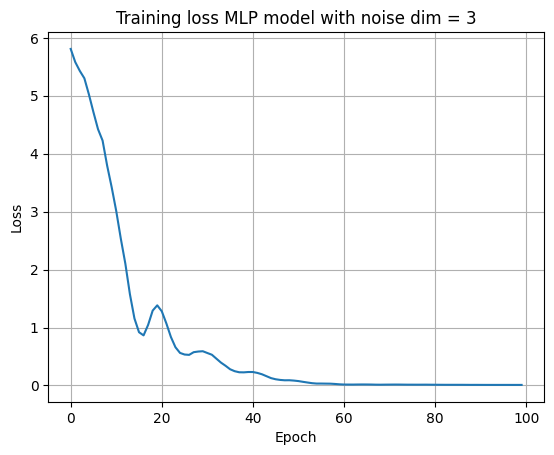

In [17]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(model.training_loss).cpu()[:100])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss MLP model with noise dim = " + str(noise_dim))
plt.grid()
plt.show()

In [11]:
len(model.training_loss)

300

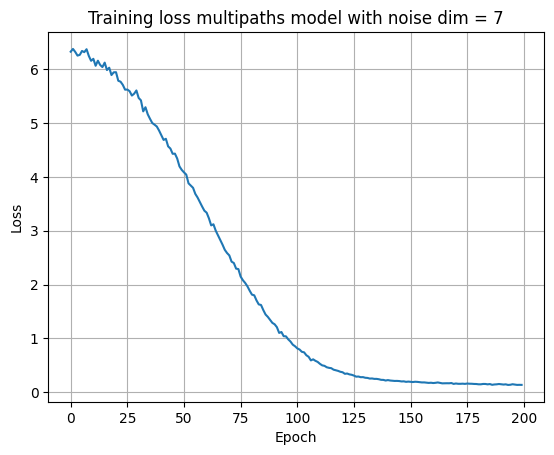

In [12]:
plt.plot(torch.tensor(path_model.training_loss).cpu()[:200])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Training loss multipaths model with noise dim = " + str(noise_dim))
plt.grid()
plt.show()

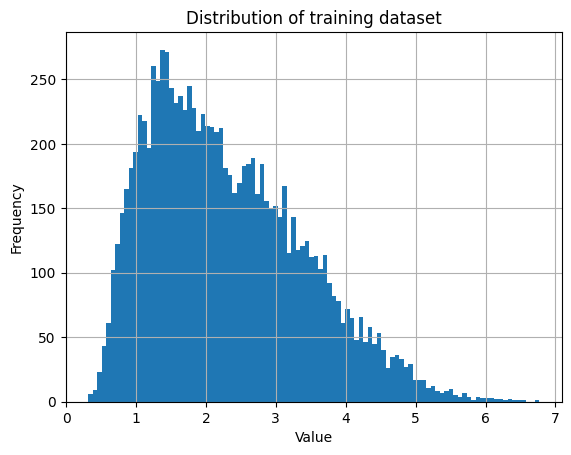

In [13]:
import matplotlib.pyplot as plt

noise_dim=3
train_x = torch.load(f'data/train_x_{noise_dim}.pt').to(torch.float32)
train_y = torch.load(f'data/train_y_{noise_dim}.pt').to(torch.float32)
test_x  =  torch.load('data/test_x.pt').to(torch.float32) #[:10,:]
test_y  =  torch.load('data/test_y.pt').to(torch.float32) #[:10]
validation_x = test_x[:len(test_x)//2,:]
validation_y = test_y[:len(test_y)//2]
test_x = test_x[len(test_x)//2:,:]
test_y = test_y[len(test_y)//2:]

plt.hist(torch.cat([test_y,validation_y]), bins=100)  # Adjust 'bins' as desired
plt.title("Distribution of training dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

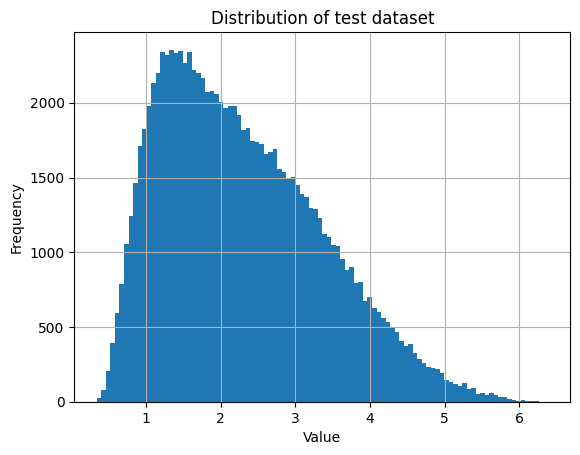

In [14]:
plt.hist(train_y, bins=100)  # Adjust 'bins' as desired
plt.title("Distribution of test dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [15]:
# train_y = train_y.numpy()
(train_y<0.1).sum()

tensor(0, device='cpu')

In [16]:
with torch.no_grad():
    y_hat = model.forward(train_x).squeeze()
y_hat.shape

plt.hist(y_hat, bins=100)  # Adjust 'bins' as desired
plt.title("Distribution of train-dataset predictions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100000x3 and 7x64)

## Test

In [ ]:
x = train_x[0].view(1,-1)
dist = torch.norm(train_x - x, dim=1)
sorted_distances, sorted_indices = torch.sort(dist)

sorted_train_x = train_x[sorted_indices]
x1 = sorted_train_x[1]
x, x1
x2 = x1 + torch.normal(0,0.1,size=(1,7)).cpu()
x2


model(x), model(x2)

(tensor([[2.5289]], device='cpu', grad_fn=<AddmmBackward0>),
 tensor([[2.3351]], device='cpu', grad_fn=<AddmmBackward0>))